In [1]:
%load_ext pypath_magic

In [2]:
%pypath -a /home/vlad/projects/analysis/qplot/

UsageError: '/home/vlad/projects/analysis/qplot' is already in the user path.


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
import plotly.express as px

import qplot
import qplot.activate

2020-10-18 11:34:01.686 | INFO     | qplot.activate:<module>:24 - IPython detected, applying inline plotting and svg figure format.


In [5]:
# important to allow plotly plots to be converted to HTML by jupyter
import plotly
plotly.offline.init_notebook_mode(connected=True)

## Data

In [6]:
rng = np.random.default_rng()
data_len = 3000
rets = pd.DataFrame(rng.standard_normal(size=(data_len, 4)), columns=list('ABCD'), index=pd.date_range('2000-01-01', periods=data_len))
rets['B'] = 0.5*rets[list('AB')].sum(1)
df = rets.cumsum()

## Line plots

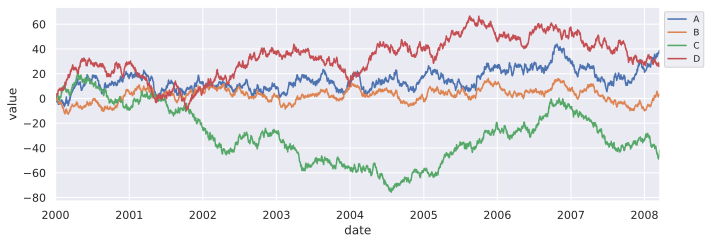

In [7]:
# matplotlib
with qplot.plot(wide=True) as p:
    df.plot(ax=p.ax())
    p.set_layout(1, xlabel='date', ylabel='value')

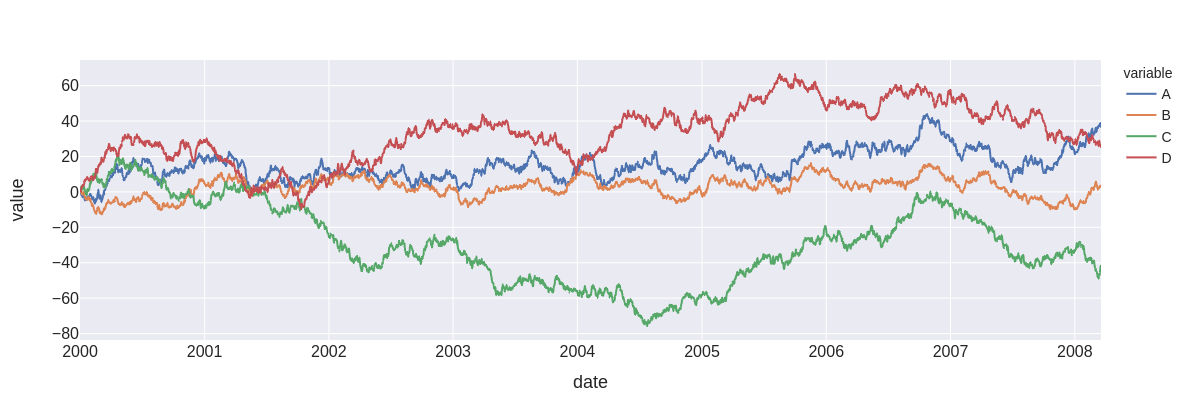

In [8]:
# plotly engine in pandas
with qplot.plot(engine='plotly', wide=True, xlabel='date') as p:
    fig = df.plot()
    p.set_fig(fig)

## Seaborn heatmap

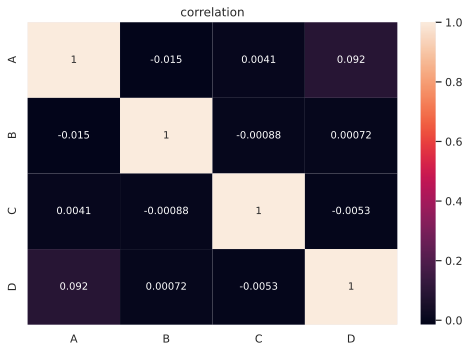

In [10]:
with qplot.plot(10, title='correlation', legend=False):
    sns.heatmap(df.pct_change().fillna(0).corr(), annot=True);

### Histogram plots

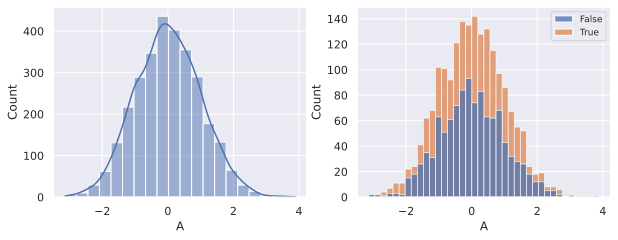

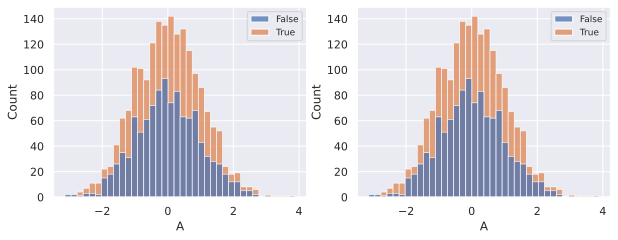

In [11]:
ser = rets['A']
cond = ser.index.to_series() > '2003'

# historgram, added KDE 
with qplot.plot(ncols=2, legend=False) as p:
    # adding KDE
    sns.histplot(x=ser, kde=True, bins=20, ax=p.ax(1))
    # using condition, stack results
    sns.histplot(x=ser, hue=cond, multiple='stack', ax=p.ax(2))
    

with qplot.plot(ncols=2, legend=False) as p:
    # adding KDE
    sns.histplot(x=ser, hue=cond, multiple='dodge', ax=p.ax(1))
    # using condition, stack results
    sns.histplot(x=ser, hue=cond, multiple='layer', ax=p.ax(2))

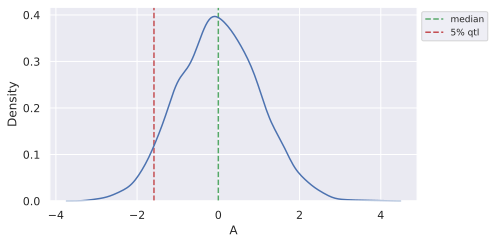

In [14]:
# KDE plot alone, can add quantile vertical lines
with qplot.plot() as p:
    plt.axvline(rets['A'].median(), label='median', ls='--', c='g')
    plt.axvline(rets['A'].quantile(0.05), label='5% qtl', ls='--', c='r')
    p = sns.kdeplot(x=rets['A'], ax=p.ax())

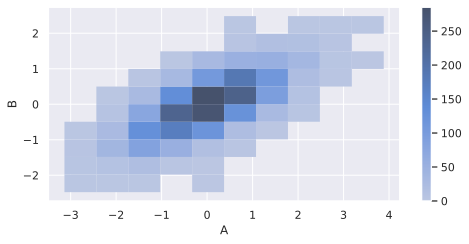

In [15]:
# 2D heatmap historgram, bins number is a tuple
with qplot.plot(legend=False):
    sns.histplot(rets, x='A', y='B', bins=(10, 10), cbar=True)

### Scatter plots, data relationships

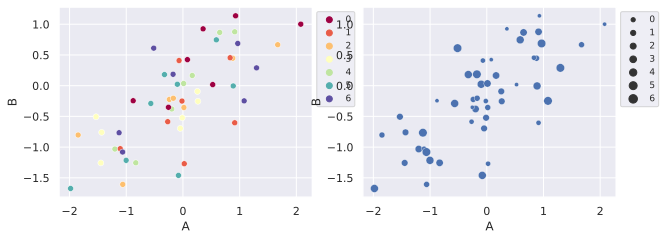

In [16]:
rets_short = rets.iloc[:50]
with qplot.plot(ncols=2) as p:
    # palette is passed to sns.color_palette
    sns.scatterplot(data=rets_short, x='A', y='B', ax=p.ax(1), hue=rets_short.index.weekday, palette='Spectral') 
    sns.scatterplot(data=rets_short, x='A', y='B', ax=p.ax(2), size=rets_short.index.weekday)  # using size to condition

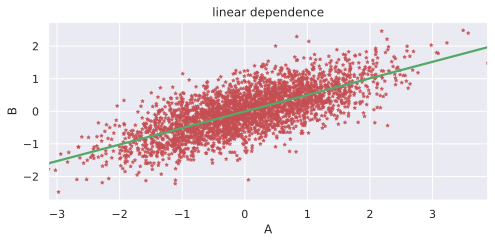

In [17]:
# adding regression line using sns.regplot (see other options)
with qplot.plot(legend=False, title='linear dependence') as p:
    sns.regplot(data=rets, x='A', y='B', ax=p.ax(), x_ci='sd', scatter_kws=dict(s=10, color='r'), ci=None, color='g', marker='*')

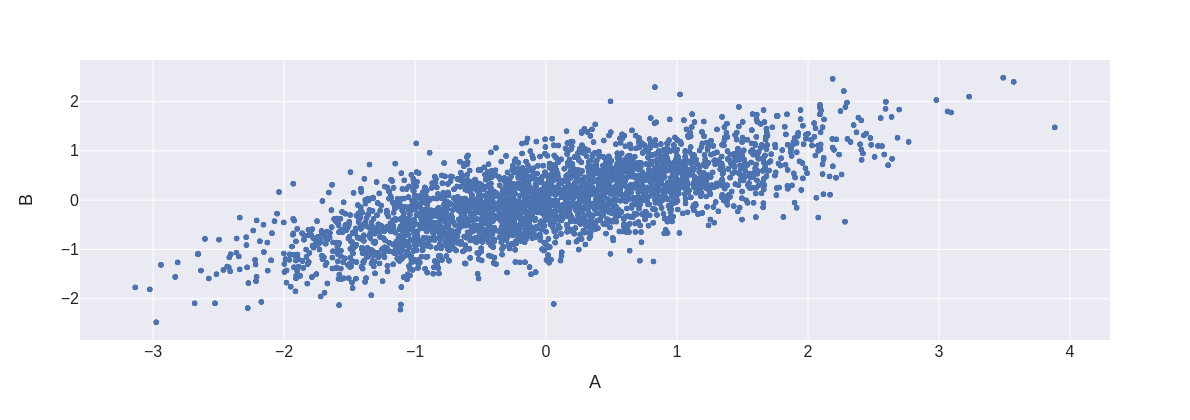

In [20]:
# plotly
with qplot.plot(7, engine='plotly', wide=True) as p:
    fig = px.scatter(rets, x='A', y='B')
    p.set_fig(fig)

## Stem plot

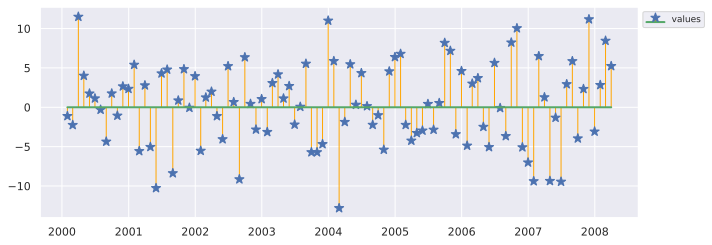

In [23]:
rets_by_month = rets['A'].resample('M').sum()
with qplot.plot(wide=True):
    qplot.Stem(marker='*', marker_size=10, base_color='g', base_lw=2, stem_color='orange').plot(x=rets_by_month.index, y=rets_by_month.values)

## QQ-Plot

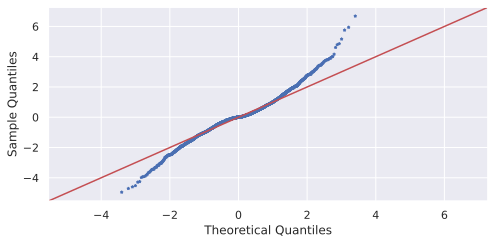

In [24]:
with qplot.plot(legend=False) as p:
    sm.qqplot(data=np.sign(rets['A'])*(rets['A']**2)**0.7, ax=p.ax(), line='45', marker='*', markersize=3)

## Colormaps

In [25]:
# idea is to create a uniform mapper between a range of values and some palette

# seaborn has a lot of palettes, e.g.
cmap=sns.color_palette('Spectral', as_cmap=True)

# normalizer with help to specify range
norm = mpl.colors.Normalize(vmin=5, vmax=10)

# get_color from palette and normalizer
get_color = lambda val: cmap(norm(val))  # val will be clipped to range

# create ScalarMappable from cmap and norm that 
scal_map = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=5, vmax=10))

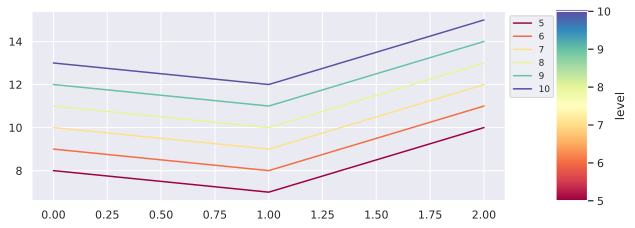

In [29]:
with qplot.plot(ncols=2, wratios=[15,1], legend=False) as p:
    for i in range(5, 11):
        p.ax(1).plot(i+np.array([3, 2, 5]), c=get_color(i), label=str(i))
    plt.colorbar(scal_map, cax=p.ax(2))  # cax arg - heatmap in a separate axis, useful we also have outside legend
    p.ax(2).set_ylabel('level')
    p.ax(1).legend(bbox_to_anchor=(1,1))  # fix - this should be automatic

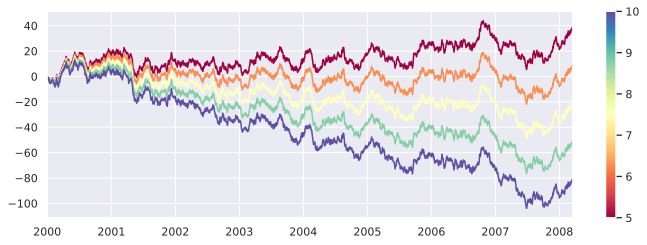

In [30]:
df_tmp = pd.concat([(rets['A'] - i*1e-2).cumsum() for i in range(5)], keys=range(5), axis=1)

with qplot.plot(legend=False, wide=True) as p:
    df_tmp.plot(cmap=cmap, ax=p.ax())
    plt.colorbar(scal_map, ax=p.ax())  # ax argument - add heatmap to the same plot
    

## Bar plots

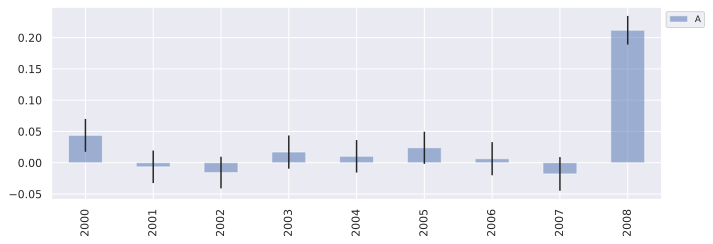

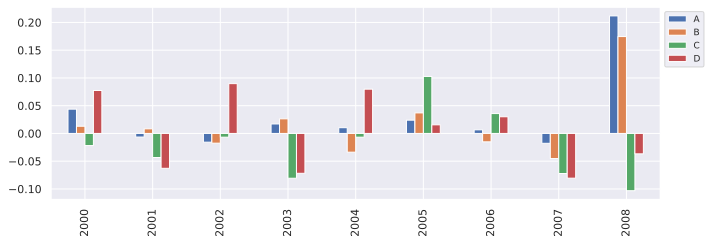

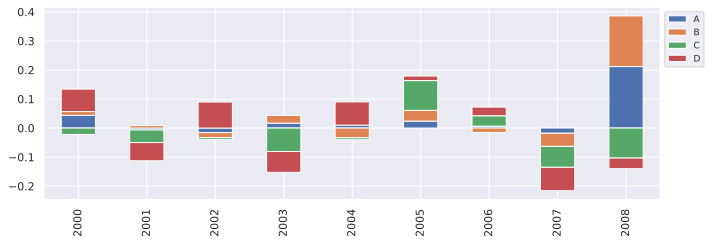

In [31]:
rets_by_year = rets.groupby(rets.index.year).mean()
std_by_year = rets.groupby(rets.index.year).std()

# adding CI
# adding transparency - works for any plot
with qplot.plot(wide=True) as p:
    rets_by_year['A'].plot.bar(ax=p.ax(), yerr=std_by_year/(2*np.sqrt(365)), alpha=0.5)

# multiple variables, plot using pandas
with qplot.plot(wide=True) as p:
    rets_by_year.plot.bar(ax=p.ax())
    
# stacked
with qplot.plot(wide=True) as p:
    rets_by_year.plot.bar(ax=p.ax(), stacked=True)

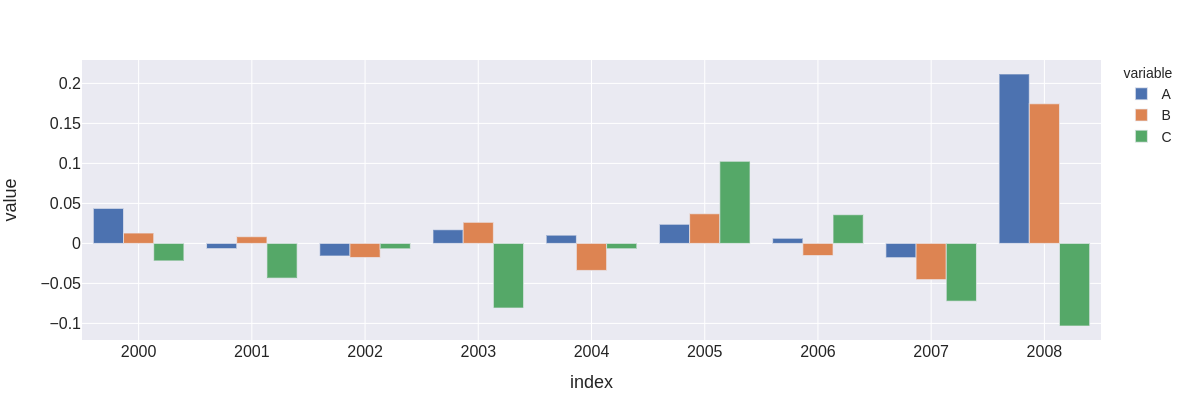

In [34]:
# pandas bar plot with plotly engine
with qplot.plot(wide=True, engine='plotly') as p:
    fig = rets_by_year[['A', 'B', 'C']].plot.bar(barmode='group')  # other barmodes: overlay, relative (same as stacked in mpl)
    p.set_fig(fig)

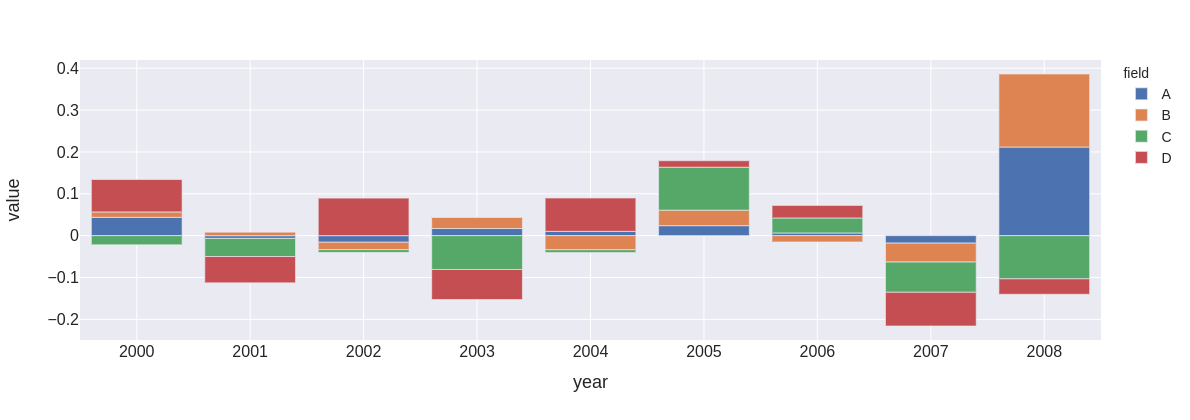

In [36]:
rets_by_year.index.name = 'year'
rets_by_year.columns.name = 'field'
df = rets_by_year.unstack().reset_index(name='value')

with qplot.plot(engine='plotly', wide=True) as p:
    fig = px.bar(df, y='value', x='year', color='field')
    p.set_fig(fig)

Look for color scales here https://plotly.com/python/builtin-colorscales/

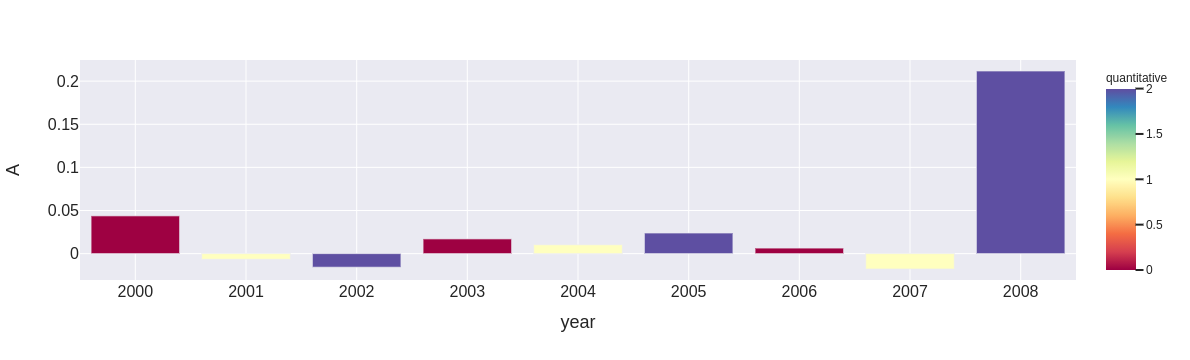

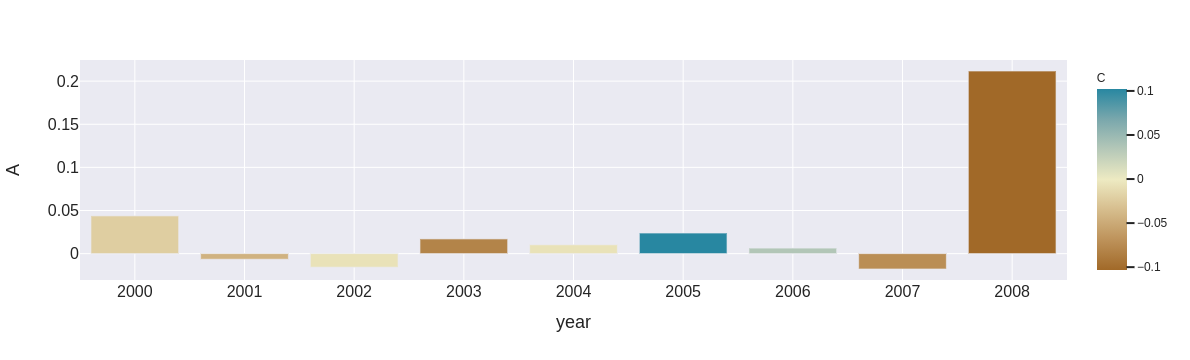

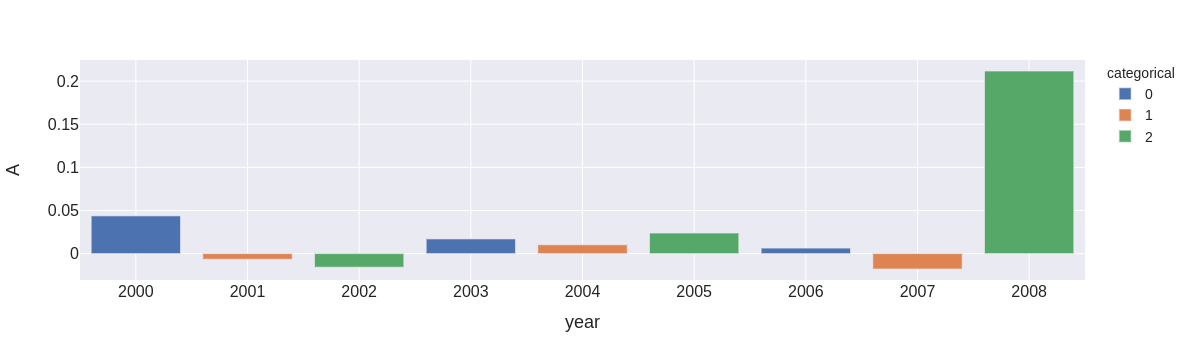

In [38]:
rets_by_year['quantitative'] = (rets_by_year.index - 2000)%3
rets_by_year['categorical'] = rets_by_year['quantitative'].astype(str)

with qplot.plot(6, engine='plotly', wide=True) as p:
    fig = px.bar(rets_by_year, y='A', x=rets_by_year.index, color='quantitative', color_continuous_scale='spectral')
    p.set_fig(fig)
    
with qplot.plot(6, engine='plotly', wide=True) as p:
    fig = px.bar(rets_by_year, y='A', x=rets_by_year.index, color='C', color_continuous_scale='earth')
    p.set_fig(fig)
    
with qplot.plot(6, engine='plotly', wide=True) as p:
    fig = px.bar(rets_by_year, y='A', x=rets_by_year.index, color='categorical')
    p.set_fig(fig)

## Bar plot value annotations 

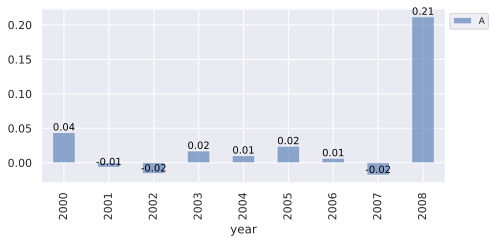

In [39]:
with qplot.plot() as p:
    rets_by_year['A'].plot.bar(ax=p.ax(), alpha=0.6)
    qplot.BarAnnotator().annotate(p.ax())

## Multple bar plots with the same xaxis index

Bar plot using x values for xtick labels, but internally values are plotted w.r.t to x-axis integer range;
plain matplotlib bar plot will plot bars with integer x values (treate as actual bar positions) correctly

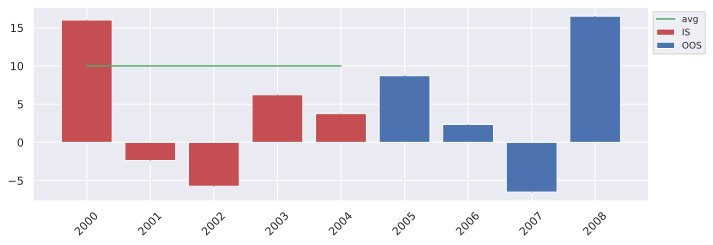

In [41]:
sum_by_year = rets['A'].groupby(rets.index.year).sum()

# multiple plots with common index (bar and others)
with qplot.plot(wide=True) as p:
    
    index = sum_by_year.index  # this is the common index
    get_loc = np.vectorize(index.get_loc)  # create vectorized version of index get_loc
    
    # condition
    cond = index.to_series() < 2005
    
    # adding two bar plots on the same x axis
    p.ax().bar(x=get_loc(sum_by_year[cond].index), height=sum_by_year[cond].to_numpy(), yerr=0.02, label='IS', color='r')
    p.ax().bar(x=get_loc(sum_by_year[~cond].index), height=sum_by_year[~cond].to_numpy(), yerr=0.02, label='OOS', color='b')
    
    # adding a line;  get_loc helps to work with indexes 
    plt.plot(get_loc(sum_by_year[cond].index), [10]*sum(cond), label='avg')
    
    # finally specify xtick (integer range), xticklabels (initial index), specify labels rotation if necessary
    p.ax().set_xticks(range(len(sum_by_year)))
    p.ax().set_xticklabels(sum_by_year.index)
    p.ax().tick_params(axis='x', rotation=45)

## Step plots
Make sense where value corresponds to interval, not to a particular point (e.g. sum over a year time period below)

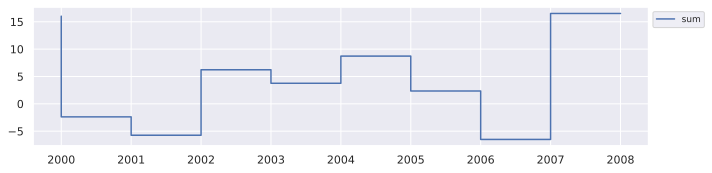

In [42]:
with qplot.plot(5, wide=True) as p:
    p.ax().step(sum_by_year.index, sum_by_year.to_numpy(), label='sum', where='pre')  # where has options: pre, post, mid

## Fill region

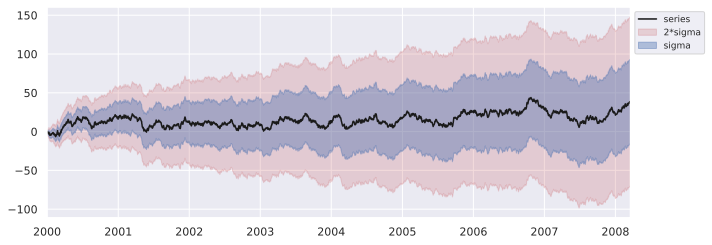

In [43]:
vol = rets['A'].std()
ser = rets['A'].cumsum()

with qplot.plot(wide=True):
    plt.fill_between(rets.index, ser - 2*vol*np.sqrt(range(len(rets))), ser + 2*vol*np.sqrt(range(len(rets))),
                      alpha=0.2, label='2*sigma', color='r');
    plt.fill_between(rets.index, ser - vol*np.sqrt(range(len(rets))), ser + vol*np.sqrt(range(len(rets))),
                      alpha=0.4, label='sigma', color='b');
    ser.plot(label='series', c='k')
    plt.legend()


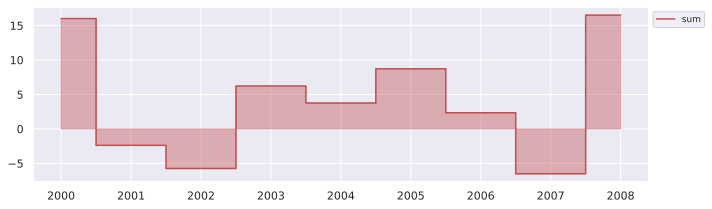

In [44]:
# fill for step plot
with qplot.plot(6, wide=True) as p:
    plt.step(sum_by_year.index, sum_by_year.values, label='sum', c='r', where='mid')
    plt.fill_between(sum_by_year.index, sum_by_year.values, np.zeros(len(sum_by_year)), 
                    color='r', step='mid', alpha=0.4)  # step arg corresponds to 'where' in plt.step

## different scales

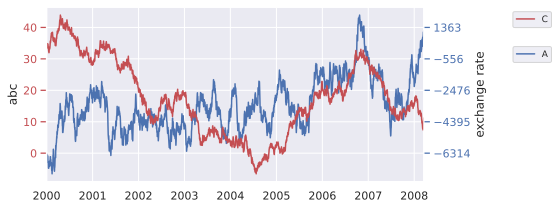

In [45]:
with qplot.plot(6, twin_ax=True, align_ticks=True) as p:
    rets['A'].cumsum().plot(ax=p.ax(), c='b')
    (100*rets['C']).cumsum().plot(ax=p.ax(2), c='r')
    
    p.set_layout(1, ylabel='abc')
    p.set_layout(2, ylabel='exchange rate')
    p.ax(1).legend(bbox_to_anchor=(1.35,0.8))
    p.ax(2).legend(bbox_to_anchor=(1.35, 1))

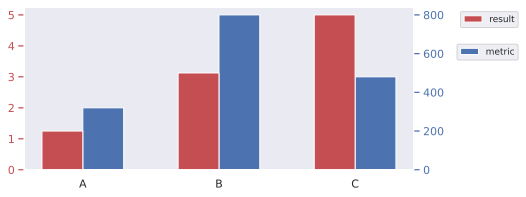

In [46]:
with qplot.plot(6, twin_ax=True, align_ticks=False, grid=False) as p:
    
    # in bar plot can specify align arg (edge or center, and width - can be positive or negative)
    # to have bar side by side choose edge and widths of different signs
    p.ax(1).bar(range(3), [2, 5, 3], align='edge', width=0.3, label='metric')
    p.ax(2).bar(range(3), [200, 500, 800], color='r', align='edge', width=-0.3, label='result')
    
    p.ax(1).set_xticks(range(3))
    p.ax(2).set_xticklabels(list('ABC'))

    p.ax(1).legend(bbox_to_anchor=(1.28,0.8))
    p.ax(2).legend(bbox_to_anchor=(1.28, 1))
    p.ax(1).grid(None)
    p.ax(2).grid(None)